## Python statistics essential training - 05_05_logistic

How can we perform model fitting when the response variables are categorical?

To answer this question, I'll follow the discussion in David Kaplan's "Statistical Modeling." An experiment with the smoking outcomes data set that we used in chapter three. So, I load packages and the data.

Standard imports

In [1]:
import math

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as pp

In [4]:
%matplotlib inline

In [5]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fix error in some versions of statsmodels
import scipy
if not hasattr(scipy.stats,'chisqprob'):
    scipy.stats.chisqprob = lambda chisq, df: scipy.stats.chi2.sf(chisq, df)

In [6]:
smoking = pd.read_csv("whickham.csv")

To improve the strength of our conclusions I have removed cases with age greater than 65, none of whom is alive after 20 years.

In [7]:
smoking = smoking[smoking.age < 65]

I have already written a function to plot nicely the data and the fit predictions

In [8]:
color = np.where(smoking.smoker == 'No','skyblue','coral')
jitter = 0.05*(np.random.rand(len(smoking)) - 0.5)
def plotfit(fit):
    pp.scatter(smoking.age,smoking.outcome + jitter,c=color,linewidth=0.2,edgecolor='k',alpha=0.5)
    pp.scatter(smoking.age,fit.predict(smoking),c=color,linewidth=0.2,edgecolor='gray',marker='d')

If I convert the smoking outcome to a binary number it becomes possible to do ordinary least squares. We'll try that first. Although, we'll see that there is a much better way. Here, I can use a Python trick. Multiplying a Boolean by an integer returns an integer.

In [9]:
smoking['outcome'] = 1 * (smoking['outcome'] == 'Alive')

Let's fit a model that includes smoking status and age as main terms.

In [10]:
ols_group_age = smf.ols('outcome ~ smoker + age', data=smoking).fit()

Let's see what our plot does. The data is plotted as circles, with orange for smokers, and light blue for non-smokers. I have added some jitter, that is, I have moved the points randomly up and down so they don't all lie on top of each other.

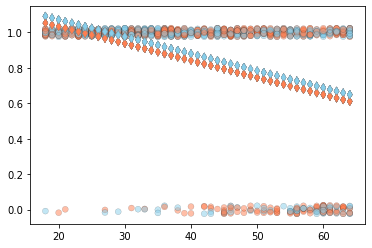

In [11]:
plotfit(ols_group_age)

The fit is represented by the diamonds at the top.

We do see there is an association between smoking and negative outcomes. The smoker term is negative.

In [12]:
ols_group_age.params

Intercept        1.264665
smoker[T.Yes]   -0.038738
age             -0.009615
dtype: float64

Let's see the ANOVA table.

In [13]:
sm.stats.anova_lm(ols_group_age)

,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,0.899981,0.899981,8.181417,4.314608e-03
age,1.0,17.713821,17.713821,161.030213,1.806638e-34
Residual,1068.0,117.483303,0.110003,NaN,NaN


The association is not especially strong with an F-statistic of eight. We have confirmation of this in the confidence interval the stats models provides for the parameters. Those rely on specific mathematical assumptions about the data, so they should be taken with a grain of salt.

In [14]:
ols_group_age.conf_int()

,0,1
Intercept,1.198828,1.330503
smoker[T.Yes],-0.078622,0.001146
age,-0.011102,-0.008129


The plot, however, shows a mathematical problem. Some predicted outcomes are larger than one.

How can we interpret that? What we need is a way to limit the output of the model to values zero and one, or perhaps even better, to values between zero and one that can be understood as the probability of one of the two outcomes.

This is done by constructing models in the usual way and then applying a non-linear function to the output. One especially useful non-linear function is the exponential logistic transformation, $\frac{exp(y)}{1 + exp(y)}$. The process of fitting such a model is called logistic regression.

![Logistic regression model](logistic.png "Logistic regression")

Stat models implements it as logit.

In [15]:
logit_smoker_age = smf.logit('outcome ~ smoker + age', data=smoking).fit()

Optimization terminated successfully.
         Current function value: 0.346766
         Iterations 7


Let's see a plot.

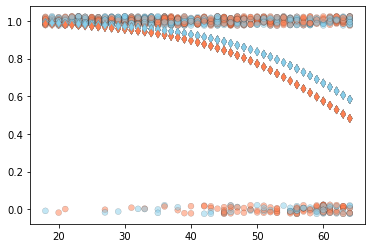

In [16]:
plotfit(logit_smoker_age)

We see now that the model is bounded between zero and one and it displays a non-linear behavior, even if we have all linear main terms.

The criteria for logistic regression is not minimizing the mean-square error of the residuals, but rather interpreting the model response as a probability function and maximizing the resulting probability of the observed data. This is a form of maximum-likelihood estimation. So instead of the main square error the simplest way to characterize goodness of fit is the value of the likelihood.

Stat models give us its logarithm. Because of the logistic transformation the model parameters are not directly comparable with the least-squares parameters.

In [17]:
logit_smoker_age.llf

-371.38650786619064

In [18]:
logit_smoker_age.params

Intercept        6.250847
smoker[T.Yes]   -0.408103
age             -0.092403
dtype: float64

Smoking reduces the probability of being alive, but not uniformly. It does so by 0.1 at the upper end of the ages, and less for younger subjects.

From the confidence intervals we see that the association with smoking remains weak.

In [20]:
logit_smoker_age.conf_int()

,0,1
Intercept,5.331126,7.170568
smoker[T.Yes],-0.777754,-0.038451
age,-0.109478,-0.075327


Stats models can tell us a lot more about this logistic regression fit. 

In [21]:
logit_smoker_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                 1071
Model:                          Logit   Df Residuals:                     1068
Method:                           MLE   Df Model:                            2
Date:                Thu, 03 Sep 2020   Pseudo R-squ.:                  0.1776
Time:                        05:06:18   Log-Likelihood:                -371.39
converged:                       True   LL-Null:                       -451.59
Covariance Type:            nonrobust   LLR p-value:                 1.469e-35
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2508      0.469     13.321      0.000       5.331       7.171
smoker[T.Yes]    -0.4081      0.189     -2.164      0.030      -0.778      -0.038
age              -0.0924      0.009    -10.606      0.000      -0.109      -0.075
=================================================================================
"""

But understanding these numbers, this requires some mathematical development. Note that the logistic model probabilities are conditional probabilities. They depend on the value of explanatory variables and they refer directly to the cases in the data set, but not necessarily to the general population. Unless we can determine that the sample is truly representative of the population. The techniques to extrapolate the results from sample to population are beyond the scope of this course, but I encourage to learn more about them.